## News Recommendation System for iPrint media

- Recommend new top 10 relevant articles to a user when he visits the app at the start of the day
- Recommend top 10 similar news articles that match the ones clicked by the user. Try different models for generating these recommendations and experiment with hybrid models for the same

### Approach :
- EDA on dataset
- Collabrative filter recommendation
    - Train/test split data and fill data matrix(distinct users * distinct items) with train and test data
    - Calculate user/item similarity on train data
    - Calculate user/item prediction matrix using test data
    - Find top 10 recommendation for specific user using above matrix (e.g. user index 117). consumer_id will be input to model. These recommendations will be shown in New section developed on iPrint media App
    - Find top 10 relavent news for 1st recommendation for user index 117. These recommendations will be shown on L2 page assuming user clicks first recommendation
- Content filter recommendation
    - Find top 10 recommendation using content filter for 1st recommendation for user index 117
- Hybrid filter recommendation
    - Combine results of Collabrative and content recommendation and show final top 10 recommendation for 1st recommendation for user index 117     
- Evaluate MAE, RMSE, Precision@10, Global Precision@10 on test data and infer effectiveness of recommndation.

In [1]:
import pandas as pd
import numpy as np

In [2]:
## Import consumer transactions
consumertxn = pd.read_csv('data/consumer_transanctions.csv')

/Users/abhishek/miniforge3/envs/test/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
## Import platform content master
platformcontent = pd.read_csv('data/platform_content.csv')

### EDA

In [4]:
consumertxn.head()

event_timestamp  interaction_type              item_id  \
0       1465413032   content_watched -3499919498720038879   
1       1465412560   content_watched  8890720798209849691   
2       1465416190   content_watched   310515487419366995   
3       1465413895  content_followed   310515487419366995   
4       1465412290   content_watched -7820640624231356730   

           consumer_id   consumer_session_id  \
0 -8845298781299428018   1264196770339959068   
1 -1032019229384696495   3621737643587579081   
2 -1130272294246983140   2631864456530402479   
3   344280948527967603  -3167637573980064150   
4  -445337111692715325  561148 1178424124714   

                                consumer_device_info consumer_location country  
0                                                NaN               NaN     NaN  
1  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...                NY      US  
2                                                NaN               NaN     NaN  
3                                                NaN               NaN     NaN  
4                                                NaN               NaN     NaN

In [5]:
platformcontent.head()

event_timestamp    interaction_type              item_id  \
0       1459192779  content_pulled_out -6451309518266745024   
1       1459193988     content_present -4110354420726924665   
2       1459194146     content_present -7292285110016212249   
3       1459194474     content_present -6151852268067518688   
4       1459194497     content_present  2448026894306402386   

           producer_id  producer_session_id producer_device_info  \
0  4340306774493623681  8940341205206233829                  NaN   
1  4340306774493623681  8940341205206233829                  NaN   
2  4340306774493623681  8940341205206233829                  NaN   
3  3891637997717104548 -1457532940883382585                  NaN   
4  4340306774493623681  8940341205206233829                  NaN   

  producer_location producer_country item_type  \
0               NaN              NaN      HTML   
1               NaN              NaN      HTML   
2               NaN              NaN      HTML   
3               NaN              NaN      HTML   
4               NaN              NaN      HTML   

                                            item_url  \
0  http://www.nytimes.com/2016/03/28/business/dea...   
1  http://www.nytimes.com/2016/03/28/business/dea...   
2  http://cointelegraph.com/news/bitcoin-future-w...   
3  https://cloudplatform.googleblog.com/2016/03/G...   
4  https://bitcoinmagazine.com/articles/ibm-wants...   

                                               title  \
0  Ethereum, a Virtual Currency, Enables Transact...   
1  Ethereum, a Virtual Currency, Enables Transact...   
2  Bitcoin Future: When GBPcoin of Branson Wins O...   
3                       Google Data Center 360° Tour   
4  IBM Wants to "Evolve the Internet" With Blockc...   

                                    text_description language  
0  All of this work is still very early. The firs...       en  
1  All of this work is still very early. The firs...       en  
2  The alarm clock wakes me at 8:00 with stream o...       en  
3  We're excited to share the Google Data Center ...       en  
4  The Aite Group projects the blockchain market ...       en

In [6]:
consumertxn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72312 entries, 0 to 72311
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   event_timestamp       72312 non-null  int64 
 1   interaction_type      72312 non-null  object
 2   item_id               72312 non-null  int64 
 3   consumer_id           72312 non-null  int64 
 4   consumer_session_id   72312 non-null  object
 5   consumer_device_info  56918 non-null  object
 6   consumer_location     56907 non-null  object
 7   country               56918 non-null  object
dtypes: int64(3), object(5)
memory usage: 4.4+ MB


In [7]:
platformcontent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3122 entries, 0 to 3121
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   event_timestamp       3122 non-null   int64 
 1   interaction_type      3122 non-null   object
 2   item_id               3122 non-null   int64 
 3   producer_id           3122 non-null   int64 
 4   producer_session_id   3122 non-null   int64 
 5   producer_device_info  680 non-null    object
 6   producer_location     680 non-null    object
 7   producer_country      680 non-null    object
 8   item_type             3122 non-null   object
 9   item_url              3122 non-null   object
 10  title                 3122 non-null   object
 11  text_description      3122 non-null   object
 12  language              3122 non-null   object
dtypes: int64(4), object(9)
memory usage: 317.2+ KB


In [8]:
consumertxn.dtypes

event_timestamp          int64
interaction_type        object
item_id                  int64
consumer_id              int64
consumer_session_id     object
consumer_device_info    object
consumer_location       object
country                 object
dtype: object

In [9]:
consumertxn.head(1)

event_timestamp interaction_type              item_id          consumer_id  \
0       1465413032  content_watched -3499919498720038879 -8845298781299428018   

   consumer_session_id consumer_device_info consumer_location country  
0  1264196770339959068                  NaN               NaN     NaN

In [10]:

consumertxn['interaction_type'].unique()

array(['content_watched', 'content_followed', 'content_saved',
       'content_liked', 'content_commented_on'], dtype=object)

In [11]:
consumertxn.isnull().sum()

event_timestamp             0
interaction_type            0
item_id                     0
consumer_id                 0
consumer_session_id         0
consumer_device_info    15394
consumer_location       15405
country                 15394
dtype: int64

In [12]:
platformcontent['language'].unique()

array(['en', 'pt', 'es', 'la', 'ja'], dtype=object)

In [13]:
platformcontent[platformcontent['language']=='en'].shape

(2264, 13)

**Derive ratings column based on user interaction with platform.**
- Impute the rating values based on the feature ‘interaction type’ with the highest weightage to content_followed, followed by content_commented_on, content saved, content liked and content_watched.

In [14]:
def convert(val):
    if val == 'content_followed':
        return 5
    elif val == 'content_commented_on':
        return 4
    elif val == 'content_saved':
        return 3
    elif val == 'content_liked':
        return 2
    else:
        return 1

In [15]:
consumertxn['rating'] = consumertxn['interaction_type'].apply(convert)

In [16]:
consumertxn.head(2)

event_timestamp interaction_type              item_id          consumer_id  \
0       1465413032  content_watched -3499919498720038879 -8845298781299428018   
1       1465412560  content_watched  8890720798209849691 -1032019229384696495   

   consumer_session_id                               consumer_device_info  \
0  1264196770339959068                                                NaN   
1  3621737643587579081  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...   

  consumer_location country  rating  
0               NaN     NaN       1  
1                NY      US       1

In [17]:
consumertxn['country'].unique()

array([nan, 'US', 'BR', 'JP', 'KR', 'IN', 'IE', 'SG', 'DE', 'CA', 'IS',
       'AU', 'ZZ', 'ES', 'CN', 'GB', 'MY', 'AR', 'NL', 'CL', 'IT', 'CO',
       'PT', 'CH'], dtype=object)

In [18]:
##Brazil seem to be using platform most
consumertxn['country'].value_counts()

BR    51396
US     4657
KR      239
CA      226
JP      144
AU      138
GB       22
DE       19
IE       14
IS       13
SG       11
ZZ       11
AR        7
PT        6
ES        3
IN        3
IT        2
MY        2
NL        1
CL        1
CN        1
CH        1
CO        1
Name: country, dtype: int64

In [19]:
import matplotlib.pyplot as plt


In [20]:
!pip install seaborn

In [21]:
import seaborn as sns


In [22]:
consumertxn.head()

event_timestamp  interaction_type              item_id  \
0       1465413032   content_watched -3499919498720038879   
1       1465412560   content_watched  8890720798209849691   
2       1465416190   content_watched   310515487419366995   
3       1465413895  content_followed   310515487419366995   
4       1465412290   content_watched -7820640624231356730   

           consumer_id   consumer_session_id  \
0 -8845298781299428018   1264196770339959068   
1 -1032019229384696495   3621737643587579081   
2 -1130272294246983140   2631864456530402479   
3   344280948527967603  -3167637573980064150   
4  -445337111692715325  561148 1178424124714   

                                consumer_device_info consumer_location  \
0                                                NaN               NaN   
1  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...                NY   
2                                                NaN               NaN   
3                                                NaN               NaN   
4                                                NaN               NaN   

  country  rating  
0     NaN       1  
1      US       1  
2     NaN       1  
3     NaN       5  
4     NaN       1

<AxesSubplot:>

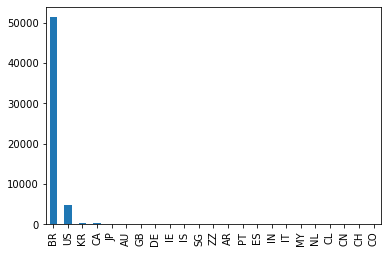

In [23]:
consumertxn['country'].value_counts().plot.bar()

In [24]:
## Sao Paulo seem to have most consumers
consumertxn['consumer_location'].value_counts()

SP    40164
MG    10229
NY     1257
TX      923
GA      910
      ...  
MT        1
ZH        1
CL        1
MN        1
33        1
Name: consumer_location, Length: 71, dtype: int64

In [25]:
## 2987 different items interacted till now
consumertxn['item_id'].nunique()

2987

In [26]:
n_items = consumertxn['item_id'].nunique()

In [27]:
## 1895 distinct customers interacted platform
consumertxn['consumer_id'].nunique()

1895

In [28]:
n_users = consumertxn['consumer_id'].nunique()

In [29]:
consumertxn.shape

(72312, 9)

In [30]:
consumertxn['interaction_type'].value_counts()

content_watched         61086
content_liked            5745
content_saved            2463
content_commented_on     1611
content_followed         1407
Name: interaction_type, dtype: int64

In [31]:
platformcontent.shape

(3122, 13)

In [32]:
platformcontent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3122 entries, 0 to 3121
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   event_timestamp       3122 non-null   int64 
 1   interaction_type      3122 non-null   object
 2   item_id               3122 non-null   int64 
 3   producer_id           3122 non-null   int64 
 4   producer_session_id   3122 non-null   int64 
 5   producer_device_info  680 non-null    object
 6   producer_location     680 non-null    object
 7   producer_country      680 non-null    object
 8   item_type             3122 non-null   object
 9   item_url              3122 non-null   object
 10  title                 3122 non-null   object
 11  text_description      3122 non-null   object
 12  language              3122 non-null   object
dtypes: int64(4), object(9)
memory usage: 317.2+ KB


In [33]:
platformcontent['interaction_type'].value_counts()

content_present       3047
content_pulled_out      75
Name: interaction_type, dtype: int64

In [34]:
## 3057 total contents present so not all contents interacted till now which hints towards need of hybrid model to add 
## content filter based recommendation into the mix
platformcontent['item_id'].nunique()

3057

In [35]:
platformcontent['producer_id'].nunique()

252

In [36]:
platformcontent['producer_country'].value_counts()

BR    613
US     59
CA      5
AU      2
PT      1
Name: producer_country, dtype: int64

In [37]:
platformcontent['item_type'].value_counts()

HTML     3101
VIDEO      11
RICH       10
Name: item_type, dtype: int64

In [38]:
platformcontent['language'].value_counts()

en    2264
pt     850
la       4
ja       2
es       2
Name: language, dtype: int64

In [39]:
platformcontent.isnull().sum()

event_timestamp            0
interaction_type           0
item_id                    0
producer_id                0
producer_session_id        0
producer_device_info    2442
producer_location       2442
producer_country        2442
item_type                  0
item_url                   0
title                      0
text_description           0
language                   0
dtype: int64

In [40]:
consumertxn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72312 entries, 0 to 72311
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   event_timestamp       72312 non-null  int64 
 1   interaction_type      72312 non-null  object
 2   item_id               72312 non-null  int64 
 3   consumer_id           72312 non-null  int64 
 4   consumer_session_id   72312 non-null  object
 5   consumer_device_info  56918 non-null  object
 6   consumer_location     56907 non-null  object
 7   country               56918 non-null  object
 8   rating                72312 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 5.0+ MB


In [41]:
#consumertxn = consumertxn[['item_id','consumer_id','rating']]

In [42]:
#consumertxn

In [43]:
#consumertxn.head()

In [44]:
from sklearn.model_selection import train_test_split
consumertxn_train, consumertxn_test = train_test_split(consumertxn, test_size=0.30, random_state=31)

In [45]:
consumertxn_train.shape

(50618, 9)

### Collabrative Filtering based Recommendation Engine

In [46]:
## Create data matrix - used as input for recommendor containg needed columns

data_matrix = consumertxn.pivot_table(
    index='consumer_id',
    columns='item_id',
    values='rating'
).fillna(0)

In [47]:
data_matrix.shape

(1895, 2987)

In [48]:
for col in data_matrix.columns:
    data_matrix[col].values[:] = 0

In [49]:
## fill with train data
for idx, line in consumertxn_train.iterrows():
    data_matrix.loc[line['consumer_id'], line['item_id']] = line['rating']

In [50]:
## used for evaluation phase
data_matrix_test = consumertxn.pivot_table(
    index='consumer_id',
    columns='item_id',
    values='rating'
).fillna(0)

In [51]:
for col in data_matrix_test.columns:
    data_matrix_test[col].values[:] = 0

In [52]:
## fill test data
for idx, line in consumertxn_test.iterrows():
    data_matrix_test.loc[line['consumer_id'], line['item_id']] = line['rating']

In [53]:
data_matrix_test.shape

(1895, 2987)

In [54]:

from sklearn.metrics.pairwise import pairwise_distances 

In [55]:
## train with train data
user_similarity = 1- pairwise_distances(data_matrix, metric='cosine')

In [56]:
user_similarity

array([[1.        , 0.        , 0.        , ..., 0.        , 0.05423261,
        0.0310535 ],
       [0.        , 1.        , 0.125     , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.125     , 1.        , ..., 0.20412415, 0.15811388,
        0.        ],
       ...,
       [0.        , 0.        , 0.20412415, ..., 1.        , 0.06454972,
        0.        ],
       [0.05423261, 0.        , 0.15811388, ..., 0.06454972, 1.        ,
        0.        ],
       [0.0310535 , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [57]:
user_similarity.shape

(1895, 1895)

In [58]:
## item similarity 
item_similarity = 1- pairwise_distances(data_matrix.T, metric='cosine')

In [59]:
item_similarity

array([[1.        , 0.        , 0.        , ..., 0.15811388, 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.03494283,
        0.        ],
       ...,
       [0.15811388, 0.        , 0.        , ..., 1.        , 0.09759001,
        0.        ],
       [0.        , 0.        , 0.03494283, ..., 0.09759001, 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [60]:
item_similarity.shape

(2987, 2987)

In [61]:
# Fill up complete data matrix using user similarity

In [62]:
item_prediction = np.dot(user_similarity,data_matrix_test)

In [63]:
item_prediction

array([[0.74595298, 0.14798606, 0.53197722, ..., 0.27367917, 0.24681865,
        0.15436108],
       [0.05904048, 0.66359629, 0.09503753, ..., 0.0118081 , 0.33354952,
        0.02265716],
       [0.13515067, 3.42017786, 0.13426786, ..., 0.07931774, 0.18338575,
        0.09319315],
       ...,
       [0.05517503, 0.66842425, 0.19482261, ..., 0.06878712, 0.        ,
        0.09773225],
       [0.20992123, 0.56117674, 0.27610456, ..., 0.07217208, 0.13735278,
        0.04461088],
       [0.14526791, 0.03223385, 0.96125553, ..., 0.02932895, 0.37975267,
        0.13582742]])

In [64]:
item_prediction.shape

(1895, 2987)

In [65]:
prediction_df = pd.DataFrame(item_prediction)

In [66]:
prediction_df.head()

0         1         2         3         4         5     6         7     \
0  0.745953  0.147986  0.531977  0.691448  0.228756  0.597210   0.0  0.243372   
1  0.059040  0.663596  0.095038  0.139059  0.000000  0.180857   0.0  0.035564   
2  0.135151  3.420178  0.134268  0.197291  0.191708  0.200713   0.0  0.219404   
3  0.278266  0.073721  0.086300  0.060704  0.140031  0.067812   0.0  0.140715   
4  0.000000  0.000000  0.853076  0.074502  0.033787  0.243158   0.0  0.038793   

   8         9     ...      2977      2978      2979  2980      2981  \
0   0.0  0.108917  ...  0.179208  0.271635  0.179737   0.0  0.277055   
1   0.0  0.000000  ...  0.000000  0.026946  0.033580   0.0  0.078087   
2   0.0  0.024427  ...  0.017070  0.193311  0.030282   0.0  0.000000   
3   0.0  0.017272  ...  0.086747  0.158063  0.066515   0.0  0.000000   
4   0.0  0.039888  ...  0.044811  0.037543  0.030117   0.0  0.146248   

       2982      2983      2984      2985      2986  
0  0.199473  0.365288  0.273679  0.246819  0.154361  
1  0.062763  0.173213  0.011808  0.333550  0.022657  
2  0.016137  0.235764  0.079318  0.183386  0.093193  
3  0.022822  0.110966  0.064927  0.045835  0.049876  
4  0.270048  0.120905  0.027277  0.093548  0.020593  

[5 rows x 2987 columns]

In [67]:
prediction_df.shape

(1895, 2987)

In [68]:
## Get top 10 recommendation for userindex 117
prediction_df.iloc[117]

0       0.417479
1       0.000000
2       0.000000
3       0.058218
4       0.077037
          ...   
2982    0.000000
2983    0.032042
2984    0.083496
2985    0.000000
2986    0.032042
Name: 117, Length: 2987, dtype: float64

In [69]:
prediction_df.iloc[117].sort_values(ascending=False)[:10]

819     2.904881
847     1.498332
702     1.243046
2539    1.079027
468     1.023391
2330    0.976865
161     0.924639
2189    0.875760
2713    0.831784
1915    0.825997
Name: 117, dtype: float64

In [70]:
recommended_movie_df = pd.DataFrame(prediction_df.iloc[117].sort_values(ascending=False))

In [71]:
recommended_movie_df.head()

117
819   2.904881
847   1.498332
702   1.243046
2539  1.079027
468   1.023391

In [72]:
recommended_movie_df.reset_index(inplace=True)

In [73]:
recommended_movie_df.head()

index       117
0    819  2.904881
1    847  1.498332
2    702  1.243046
3   2539  1.079027
4    468  1.023391

In [74]:
recommended_movie_df.columns = ['item_id', 'score']

In [75]:
recommended_movie_df.head(10)

item_id     score
0      819  2.904881
1      847  1.498332
2      702  1.243046
3     2539  1.079027
4      468  1.023391
5     2330  0.976865
6      161  0.924639
7     2189  0.875760
8     2713  0.831784
9     1915  0.825997

In [76]:
recommended_movie_df['item_id'] = recommended_movie_df['item_id'].apply(lambda x : data_matrix_test.columns[x])

In [77]:
merged_user = pd.merge(recommended_movie_df, platformcontent, on='item_id', how='left')

In [78]:
merged_user.head(10)

item_id     score  event_timestamp interaction_type  \
0 -4205346868684833897  2.904881       1465950308  content_present   
1 -4029704725707465084  1.498332       1487246811  content_present   
2 -5002383425685129595  1.243046       1467123962  content_present   
3  6535950170823528902  1.079027       1462453699  content_present   
4 -6467708104873171151  1.023391       1461879742  content_present   
5  5238119115012015307  0.976865       1461608361  content_present   
6 -8370744479086515302  0.924639       1464779739  content_present   
7  4419562057180692966  0.875760       1466862481  content_present   
8  7516228655554309785  0.831784       1462816920  content_present   
9  2719909253419802298  0.825997       1466605328  content_present   

           producer_id  producer_session_id  \
0 -1443636648652872475  6340331642204025925   
1  6013226412048763966 -6569695881431984742   
2 -3390049372067052505  2471338745689678750   
3 -1387464358334758758 -3296390452744498738   
4 -1032019229384696495 -1941773591979139720   
5 -3390049372067052505  6068971232842203123   
6  1895326251577378793  2217251992734926463   
7 -1032019229384696495  6917925448322846329   
8 -3390049372067052505 -8729604331807064886   
9 -5527145562136413747   101989957506145943   

                                producer_device_info producer_location  \
0                                                NaN               NaN   
1  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...                SP   
2                                                NaN               NaN   
3                                                NaN               NaN   
4                                                NaN               NaN   
5                                                NaN               NaN   
6                                                NaN               NaN   
7                                                NaN               NaN   
8                                                NaN               NaN   
9                                                NaN               NaN   

  producer_country item_type  \
0              NaN      HTML   
1               BR      HTML   
2              NaN      HTML   
3              NaN      HTML   
4              NaN      HTML   
5              NaN      HTML   
6              NaN      HTML   
7              NaN      HTML   
8              NaN      HTML   
9              NaN      HTML   

                                            item_url  \
0  http://techcrunch.com/2016/06/14/google-launch...   
1  http://www.cnbc.com/2016/12/21/former-google-c...   
2  http://www.mckinsey.com/global-themes/leadersh...   
3  http://googlediscovery.com/2016/05/04/google-s...   
4  http://justcuriousblog.com/2016/04/5-reasons-y...   
5            https://hbr.org/2016/05/embracing-agile   
6  http://computerworld.com.br/mobile-banking-con...   
7  https://techcrunch.com/2016/06/25/latin-americ...   
8  http://www.mckinsey.com/industries/financial-s...   
9  http://blog.runrun.it/mulheres-millenials-gera...   

                                               title  \
0  Google launches Springboard, an AI-powered ass...   
1  Former Google career coach shares a visual tri...   
2                         Changing change management   
3  Google Slides incorpora recurso de "perguntas ...   
4  5 reasons your employees aren't sharing their ...   
5                                    Embracing Agile   
6  Mobile banking conquista o coração dos brasile...   
7  Latin America's chronic inefficiency could dri...   
8        A digital crack in banking's business model   
9  As expectativas das mulheres da Geração Y são ...   

                                    text_description language  
0  Google has unwrapped two significant announcem...       en  
1  If you want 2017 to be an exciting year, desig...       en  
2  Research tells us that most change efforts fai...       en  
3  Utilizando a tecnologia do extinto Google Mode...       pt  
4  I

In [79]:
## Lets get recommendation for user index 117
data_matrix.index[117]

-8078450058314350213

In [80]:
## Already watched contents for user index 117
alreadyWatchedItems = consumertxn[(consumertxn['consumer_id']==data_matrix.index[117]) & (consumertxn['interaction_type']=='content_watched')]['item_id']

In [81]:
##  top 10 news for customer id -8078450058314350213 - 
## This can be shown in new section for Iprint containing top 10 recommendation customized for user index 117
## only show valid contents and new ones
merged_user[(merged_user['interaction_type']!='content_pulled_out')&(~merged_user['item_id'].isin(alreadyWatchedItems))]['title'].head(10)

2                            Changing change management
3     Google Slides incorpora recurso de "perguntas ...
4     5 reasons your employees aren't sharing their ...
5                                       Embracing Agile
6     Mobile banking conquista o coração dos brasile...
7     Latin America's chronic inefficiency could dri...
8           A digital crack in banking's business model
9     As expectativas das mulheres da Geração Y são ...
10          Building a technical career path at Spotify
11      Microsoft adquire LinkedIn por US$ 26,2 bilhões
Name: title, dtype: object

In [82]:
## item similarity - 10 news relavent to 1st recommendation for user 117  

In [83]:
data_matrix.columns.get_loc(-5002383425685129595)

702

In [84]:
movie_index = 702

In [85]:
movie_prediction = pd.DataFrame(item_similarity)

In [86]:
movie_prediction.shape

(2987, 2987)

In [87]:
movie_prediction.iloc[movie_index]

0       0.034669
1       0.020447
2       0.015702
3       0.076570
4       0.056614
          ...   
2982    0.040032
2983    0.067488
2984    0.087706
2985    0.085592
2986    0.000000
Name: 702, Length: 2987, dtype: float64

In [88]:
item_recommendation = pd.DataFrame(movie_prediction.iloc[movie_index].sort_values(ascending=False))

In [89]:
item_recommendation.head()

702
702   1.000000
587   0.481812
470   0.433360
983   0.400320
2532  0.397678

In [90]:
item_recommendation.reset_index(inplace=True)

In [91]:
item_recommendation.head()

index       702
0    702  1.000000
1    587  0.481812
2    470  0.433360
3    983  0.400320
4   2532  0.397678

In [92]:
item_recommendation.columns = ['item_id', 'score']

In [93]:
item_recommendation['item_id'] = item_recommendation['item_id'].apply(lambda x : data_matrix.columns[x])

In [94]:
item_recommendation.head()

item_id     score
0 -5002383425685129595  1.000000
1 -5679515279292214033  0.481812
2 -6463637573325658465  0.433360
3 -3179358869851478234  0.400320
4  6504364365389213533  0.397678

In [95]:
## item_recommendation will be used for hybrid model.
item_recommendation['collaborative_score_normalized'] = (item_recommendation['score']-min(item_recommendation['score']))/(max(item_recommendation['score'])-min(item_recommendation['score']))

In [96]:
merged = pd.merge(item_recommendation, platformcontent, on='item_id', how='left')

In [97]:
merged.head()

item_id     score  collaborative_score_normalized  \
0 -5002383425685129595  1.000000                        1.000000   
1 -5679515279292214033  0.481812                        0.481812   
2 -6463637573325658465  0.433360                        0.433360   
3 -3179358869851478234  0.400320                        0.400320   
4  6504364365389213533  0.397678                        0.397678   

   event_timestamp interaction_type          producer_id  producer_session_id  \
0       1467123962  content_present -3390049372067052505  2471338745689678750   
1       1470318792  content_present -2337468721613240548  4221156670710402439   
2       1472215855  content_present -6067316262393890508  6987480795989757055   
3       1475080725  content_present -6067316262393890508 -3241693240320572210   
4       1469105350  content_present -2337468721613240548   415995522850680396   

                                producer_device_info producer_location  \
0                                                NaN               NaN   
1                                                NaN               NaN   
2                                                NaN               NaN   
3  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_1...                SP   
4                                                NaN               NaN   

  producer_country item_type  \
0              NaN      HTML   
1              NaN      HTML   
2              NaN      HTML   
3               BR      HTML   
4              NaN      HTML   

                                            item_url  \
0  http://www.mckinsey.com/global-themes/leadersh...   
1  http://carplace.uol.com.br/mulheres-ja-respond...   
2  http://www.sonhoseguro.com.br/2016/08/carros-c...   
3  http://insurancethoughtleadership.com/not-your...   
4  http://economia.uol.com.br/noticias/efe/2016/0...   

                                               title  \
0                         Changing change management   
1  Honda: mulheres já respondem por 50% das venda...   
2  Carros conectados impulsionarão diferentes ind...   
3  Not Your Father's Insurance Industry - Insuran...   
4  Honda e Softbank desenvolverão sistema de IA p...   

                                    text_description language  
0  Research tells us that most change efforts fai...       en  
1  A atual crise econômica tem provocado uma muda...       pt  
2  Fonte: Artigo de Ronald Rowlands, consultor de...       pt  
3  Summary: New ecosystems provide tremendous opp...       en  
4  Tóquio, 21 jul (EFE).- A fabricante de veículo...       pt

In [98]:
merged.shape

(3049, 15)

In [99]:
## Top 10 relavent articles corresponding to 1st suggestion for user index 117
## This can be shown in Level 2 once user click 1st recommendation 
merged.head(11)['title'][1:11]

1     Honda: mulheres já respondem por 50% das venda...
2     Carros conectados impulsionarão diferentes ind...
3     Not Your Father's Insurance Industry - Insuran...
4     Honda e Softbank desenvolverão sistema de IA p...
5     Creating value in auto finance with vLendRight...
6     Build your own scalable, location analysis pla...
7     Latin America's chronic inefficiency could dri...
8     Especial Agrishow: Soluções de agricultura de ...
9     How to forecast demand with Google BigQuery, p...
10    Google acquires deep search engine Kifi to enh...
Name: title, dtype: object

### Content Based filtering recommendation Engine

In [100]:
## consider English Articles only per problem description
platformcontent_contentModel = platformcontent[platformcontent['language']=='en']

In [101]:
## Derive keywords column to be used for TF-IDF model later
platformcontent_contentModel['keywords']=platformcontent_contentModel['text_description']

<ipython-input-101-4073d77c3960>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  platformcontent_contentModel['keywords']=platformcontent_contentModel['text_description']


In [102]:
platformcontent_contentModel['keywords']

0       All of this work is still very early. The firs...
1       All of this work is still very early. The firs...
2       The alarm clock wakes me at 8:00 with stream o...
3       We're excited to share the Google Data Center ...
4       The Aite Group projects the blockchain market ...
                              ...                        
3116    For the past year , we've ranked nearly 9,000 ...
3118    Amazon has launched Chime, a video conferencin...
3119    February 9, 2017 - We begin each year with a l...
3120    At JPMorgan Chase & Co., a learning machine is...
3121    The Acquia Partner Awards Program is comprised...
Name: keywords, Length: 2264, dtype: object

In [103]:
## Data cleaning for Keywords column

from gensim.corpora.dictionary import Dictionary
from nltk.corpus import stopwords

#Data cleaning
platformcontent_contentModel['keywords'] = platformcontent_contentModel['keywords'].replace(r'\'|\"|\,|\.|\?|\+|\-|\/|\=|\(|\)|\n|"', '', regex=True)
platformcontent_contentModel['keywords'] = platformcontent_contentModel['keywords'].replace("  ", " ")

platformcontent_contentModel['keywords'] = platformcontent_contentModel['keywords'].replace(r'<ed>','', regex = True)
platformcontent_contentModel['keywords'] = platformcontent_contentModel['keywords'].replace(r'\B<U+.*>|<U+.*>\B|<U+.*>','', regex = True)
    
# convert keys to lowercase
platformcontent_contentModel['keywords'] = platformcontent_contentModel['keywords'].str.lower()
    
#remove user mentions
platformcontent_contentModel['keywords'] = platformcontent_contentModel['keywords'].replace(r'^(@\w+)',"", regex=True)

#remove 'rt' in the beginning
platformcontent_contentModel['keywords'] = platformcontent_contentModel['keywords'].replace(r'^(rt @)',"", regex=True)

#remove_symbols
platformcontent_contentModel['keywords'] = platformcontent_contentModel['keywords'].replace(r'[^a-zA-Z0-9]', " ", regex=True)

#remove punctuations 
platformcontent_contentModel['keywords'] = platformcontent_contentModel['keywords'].replace(r'[[]!"#$%\'()\*+,-./:;<=>?^_`{|}]+',"", regex = True)

#remove_URL(x):
platformcontent_contentModel['keywords'] = platformcontent_contentModel['keywords'].replace(r'https.*$', "", regex = True)

#remove 'amp' in the text
platformcontent_contentModel['keywords'] = platformcontent_contentModel['keywords'].replace(r'amp',"", regex = True)

#remove words of length 1 or 2 
platformcontent_contentModel['keywords'] = platformcontent_contentModel['keywords'].replace(r'\b[a-zA-Z]{1,2}\b','', regex=True)

#remove extra spaces in the keywords
platformcontent_contentModel['keywords'] = platformcontent_contentModel['keywords'].replace(r'^\s+|\s+$'," ", regex=True)


words_remove = ["ax","i","you","edu","s","t","m","subject","can","lines","re","what", "there","all","we",
                "one","the","a","an","of","or","in","for","by","on","but","is","in","a","not","with","as",
                "was","if","they","are","this","and","it","have","has","from","at","my","be","by","not","that","to",
                "from","com","org","like","likes","so","said","from","what","told","over","more","other",
                "have","last","with","this","that","such","when","been","says","will","also","where","why",
                "would","today", "in", "on", "you", "r", "d", "u", "hw","wat", "oly", "s", "b", "ht", 
                "rt", "p","the","th", "n", "was"]

#remove stopwords and words_to_remove
stop_words = set(stopwords.words('english'))
mystopwords = [stop_words, "via", words_remove]

platformcontent_contentModel['keywords'] = platformcontent_contentModel['keywords'].apply(lambda x: ' '.join([word for word in x.split() if word not in mystopwords]))
    

/Users/abhishek/miniforge3/envs/test/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
<ipython-input-103-b8455295b574>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  platformcontent_contentModel['keywords'] = platformcontent_contentModel['keywords'].replace(r'\'|\"|\,|\.|\?|\+|\-|\/|\=|\(|\)|\n|"', '', regex=True)
<ipython-input-103-b8455295b574>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

In [104]:
platformcontent_contentModel['keywords']

0       all this work still very early the first full ...
1       all this work still very early the first full ...
2       the alarm clock wakes 8 00 with stream advertf...
3       were excited share the google data center 360 ...
4       the aite group projects the blockchain market ...
                              ...                        
3116    for the past year weve ranked nearly 9000 swif...
3118    amazon has launched chime video conferencing a...
3119    february 9 2017 begin each year with look the ...
3120    jpmorgan chase learning machine parsing financ...
3121    the acquia partner awards program comprised tw...
Name: keywords, Length: 2264, dtype: object

In [105]:
platformcontent_contentModel['keywords'] = platformcontent_contentModel['keywords'].apply(lambda x:x.split(' '))

<ipython-input-105-1f675be5e24d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  platformcontent_contentModel['keywords'] = platformcontent_contentModel['keywords'].apply(lambda x:x.split(' '))


In [106]:
platformcontent_contentModel['keywords']

0       [all, this, work, still, very, early, the, fir...
1       [all, this, work, still, very, early, the, fir...
2       [the, alarm, clock, wakes, 8, 00, with, stream...
3       [were, excited, share, the, google, data, cent...
4       [the, aite, group, projects, the, blockchain, ...
                              ...                        
3116    [for, the, past, year, weve, ranked, nearly, 9...
3118    [amazon, has, launched, chime, video, conferen...
3119    [february, 9, 2017, begin, each, year, with, l...
3120    [jpmorgan, chase, learning, machine, parsing, ...
3121    [the, acquia, partner, awards, program, compri...
Name: keywords, Length: 2264, dtype: object

In [107]:
keywords_array = platformcontent_contentModel['keywords'].to_numpy()

In [108]:
keywords_array[0]

['all',
 'this',
 'work',
 'still',
 'very',
 'early',
 'the',
 'first',
 'full',
 'public',
 'version',
 'the',
 'ethereum',
 'software',
 'was',
 'recently',
 'released',
 'and',
 'the',
 'system',
 'could',
 'face',
 'some',
 'the',
 'same',
 'technical',
 'and',
 'legal',
 'problems',
 'that',
 'have',
 'tarnished',
 'bitcoin',
 'many',
 'bitcoin',
 'advocates',
 'say',
 'ethereum',
 'will',
 'face',
 'more',
 'security',
 'problems',
 'than',
 'bitcoin',
 'because',
 'the',
 'greater',
 'complexity',
 'the',
 'software',
 'thus',
 'far',
 'ethereum',
 'has',
 'faced',
 'much',
 'less',
 'testing',
 'and',
 'many',
 'fewer',
 'attacks',
 'than',
 'bitcoin',
 'the',
 'novel',
 'design',
 'ethereum',
 'may',
 'also',
 'invite',
 'intense',
 'scrutiny',
 'authorities',
 'given',
 'that',
 'potentially',
 'fraudulent',
 'contracts',
 'like',
 'the',
 'ponzi',
 'schemes',
 'can',
 'written',
 'directly',
 'into',
 'the',
 'ethereum',
 'system',
 'but',
 'the',
 'sophisticated',
 'capabi

In [109]:
words_list = []
for keyword in keywords_array:
    words_list.append(keyword)

In [110]:
len(words_list)

2264

In [111]:
words_list[7]

['when',
 'most',
 'people',
 'think',
 'about',
 'computers',
 'and',
 'robots',
 'taking',
 'jobs',
 'away',
 'from',
 'humans',
 'the',
 'images',
 'that',
 'usually',
 'come',
 'mind',
 'are',
 'robots',
 'moving',
 'inventory',
 'around',
 'amazon',
 'warehouse',
 'mcdonalds',
 'customers',
 'placing',
 'their',
 'order',
 'tablet',
 'instead',
 'cashier',
 'but',
 'the',
 'robots',
 'are',
 'coming',
 'for',
 'much',
 'more',
 'sophisticated',
 'jobs',
 'well',
 'for',
 'exle',
 'blockchain',
 'technology',
 'out',
 'eat',
 'the',
 'lunches',
 'some',
 'professionals',
 'the',
 'traditional',
 'financial',
 'system',
 'theres',
 'lot',
 'mistrust',
 'the',
 'banking',
 'system',
 'recent',
 'blockchainfocused',
 'event',
 'toronto',
 'bitcoin',
 'core',
 'contributor',
 'peter',
 'todd',
 'was',
 'asked',
 'explain',
 'the',
 'reasoning',
 'behind',
 'wall',
 'streets',
 'increased',
 'interest',
 'blockchain',
 'technology',
 'during',
 'his',
 'initial',
 'response',
 'todd',
 

In [112]:
!pip install nltk

In [113]:
## create dictionary for word list ##

In [114]:
dictionary = Dictionary(words_list) 

In [115]:
len(dictionary)

57544

In [116]:
number_words = 0
for word in words_list:
    number_words = number_words + len(word)

In [117]:
number_words

1806049

In [118]:
dictionary.get(0), dictionary.get(1), dictionary.get(100)

('1', '10', 'deliver')

In [119]:
words_list[0]

['all',
 'this',
 'work',
 'still',
 'very',
 'early',
 'the',
 'first',
 'full',
 'public',
 'version',
 'the',
 'ethereum',
 'software',
 'was',
 'recently',
 'released',
 'and',
 'the',
 'system',
 'could',
 'face',
 'some',
 'the',
 'same',
 'technical',
 'and',
 'legal',
 'problems',
 'that',
 'have',
 'tarnished',
 'bitcoin',
 'many',
 'bitcoin',
 'advocates',
 'say',
 'ethereum',
 'will',
 'face',
 'more',
 'security',
 'problems',
 'than',
 'bitcoin',
 'because',
 'the',
 'greater',
 'complexity',
 'the',
 'software',
 'thus',
 'far',
 'ethereum',
 'has',
 'faced',
 'much',
 'less',
 'testing',
 'and',
 'many',
 'fewer',
 'attacks',
 'than',
 'bitcoin',
 'the',
 'novel',
 'design',
 'ethereum',
 'may',
 'also',
 'invite',
 'intense',
 'scrutiny',
 'authorities',
 'given',
 'that',
 'potentially',
 'fraudulent',
 'contracts',
 'like',
 'the',
 'ponzi',
 'schemes',
 'can',
 'written',
 'directly',
 'into',
 'the',
 'ethereum',
 'system',
 'but',
 'the',
 'sophisticated',
 'capabi

In [120]:
## convert to BOW for using in model
bow = dictionary.doc2bow(words_list[0])

In [121]:
bow

[(0, 2),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 2),
 (13, 1),
 (14, 1),
 (15, 3),
 (16, 1),
 (17, 1),
 (18, 1),
 (19, 4),
 (20, 1),
 (21, 2),
 (22, 3),
 (23, 1),
 (24, 1),
 (25, 17),
 (26, 1),
 (27, 3),
 (28, 1),
 (29, 1),
 (30, 5),
 (31, 5),
 (32, 1),
 (33, 1),
 (34, 1),
 (35, 1),
 (36, 1),
 (37, 1),
 (38, 1),
 (39, 1),
 (40, 3),
 (41, 1),
 (42, 1),
 (43, 1),
 (44, 6),
 (45, 1),
 (46, 3),
 (47, 2),
 (48, 1),
 (49, 16),
 (50, 5),
 (51, 4),
 (52, 1),
 (53, 2),
 (54, 1),
 (55, 2),
 (56, 1),
 (57, 1),
 (58, 1),
 (59, 1),
 (60, 1),
 (61, 4),
 (62, 2),
 (63, 2),
 (64, 1),
 (65, 2),
 (66, 3),
 (67, 1),
 (68, 1),
 (69, 1),
 (70, 1),
 (71, 1),
 (72, 1),
 (73, 1),
 (74, 2),
 (75, 1),
 (76, 1),
 (77, 3),
 (78, 2),
 (79, 1),
 (80, 2),
 (81, 1),
 (82, 2),
 (83, 1),
 (84, 2),
 (85, 1),
 (86, 2),
 (87, 1),
 (88, 3),
 (89, 3),
 (90, 1),
 (91, 1),
 (92, 1),
 (93, 3),
 (94, 1),
 (95, 1),
 (96, 1),
 (97, 1),
 (98, 1),
 (99, 1),
 (100, 1

In [122]:
len(words_list[0]), len(bow)

(861, 443)

In [123]:
## Corpus 
corpus = [dictionary.doc2bow(doc) for doc in words_list] 

In [124]:
corpus

[[(0, 2),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 2),
  (13, 1),
  (14, 1),
  (15, 3),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 4),
  (20, 1),
  (21, 2),
  (22, 3),
  (23, 1),
  (24, 1),
  (25, 17),
  (26, 1),
  (27, 3),
  (28, 1),
  (29, 1),
  (30, 5),
  (31, 5),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 3),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 6),
  (45, 1),
  (46, 3),
  (47, 2),
  (48, 1),
  (49, 16),
  (50, 5),
  (51, 4),
  (52, 1),
  (53, 2),
  (54, 1),
  (55, 2),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 4),
  (62, 2),
  (63, 2),
  (64, 1),
  (65, 2),
  (66, 3),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 2),
  (75, 1),
  (76, 1),
  (77, 3),
  (78, 2),
  (79, 1),
  (80, 2),
  (81, 1),
  (82, 2),
  (83, 1),
  (84, 2),
  (85, 1),
  (86, 2),
  (87, 1),
  (88, 3),
  (89, 3),
  (90, 1),
  (91, 

In [125]:
len(corpus), len(corpus[0]), len(corpus[1])

(2264, 443, 443)

In [126]:
len(words_list), len(words_list[0])

(2264, 861)

In [127]:

from gensim.models.tfidfmodel import TfidfModel

In [128]:
## TF-IDF model
tfidf = TfidfModel(corpus)

In [129]:
tfidf

In [130]:
tfidf[corpus[0]]

[(0, 0.017672995178912843),
 (1, 0.010074052692964004),
 (2, 0.016389251799103936),
 (3, 0.020637396999822137),
 (4, 0.00949353885699013),
 (5, 0.023927749424854376),
 (6, 0.01574757619495828),
 (7, 0.04326763174249039),
 (8, 0.014466563178080951),
 (9, 0.04326763174249039),
 (10, 0.014361666054957659),
 (11, 0.04326763174249039),
 (12, 0.0051859952792757255),
 (13, 0.015495189010045842),
 (14, 0.03233705863828504),
 (15, 0.019633361311963936),
 (16, 0.023183726969314932),
 (17, 0.029422935295260647),
 (18, 0.02091529874763759),
 (19, 0.008042215592635488),
 (20, 0.015588694743759825),
 (21, 0.021274614672779645),
 (22, 0.007283361198417417),
 (23, 0.03874158479395674),
 (24, 0.02120555566562452),
 (25, 0.0010839455203261908),
 (26, 0.00680086779003925),
 (27, 0.013821919663216942),
 (28, 0.011302443608791745),
 (29, 0.0100203099575876),
 (30, 0.005329764159449029),
 (31, 0.033598257503196706),
 (32, 0.01855798792422892),
 (33, 0.026035364615526992),
 (34, 0.029689490896889437),
 (35, 

In [131]:
from gensim.similarities import MatrixSimilarity

In [132]:
sims = MatrixSimilarity(tfidf[corpus], num_features=len(dictionary))

In [133]:
print(sims)

MatrixSimilarity<2264 docs, 57544 features>


In [134]:
sims[corpus[0]]

array([0.48792502, 0.48792502, 0.02248674, ..., 0.04783712, 0.0683274 ,
       0.01579095], dtype=float32)

In [135]:
len(sims[corpus[0]])

2264

In [136]:
def item_recommendation_func(item):
    movie = platformcontent_contentModel.loc[platformcontent_contentModel.item_id==item] # get the movie row
    keywords = platformcontent_contentModel.loc[platformcontent_contentModel.item_id==item]['keywords'].iloc[0] #get the keywords as a Series (movie['keywords']),
    # get just the keywords string ([0]), and then convert to a list of keywords (.split(',') )
    query_doc = keywords #set the query_doc to the list of keywords
    
    query_doc_bow = dictionary.doc2bow(query_doc) # get a bag of words from the query_doc
    query_doc_tfidf = tfidf[query_doc_bow] #convert the regular bag of words model to a tf-idf model where we have tuples
    # of the movie ID and it's tf-idf value for the movie

    similarity_array = sims[query_doc_tfidf] # get the array of similarity values between our movie and every other movie. 
    #So the length is the number of movies we have. To do this, we pass our list of tf-idf tuples to sims.

    similarity_series = pd.Series(similarity_array.tolist(), index=platformcontent_contentModel.item_id.values) #Convert to a Series
    recommended_movies = similarity_series.sort_values(ascending=False)
    return recommended_movies

In [137]:
#content filtering based recommendation for 1st article for user index 117 
#- we have got collab filtering o/p of this previously
item_recommendation_func(-5002383425685129595)

-5002383425685129595    1.000000
-8187220755213888616    0.221300
 5533752987392101383    0.194789
-2271868873349907631    0.193857
 4785499183287168509    0.187494
                          ...   
 476793294516827044     0.001826
-1853084798056642222    0.001826
 408569329455206654     0.001652
-6511498353814468913    0.001562
 1805789466376069146    0.000000
Length: 2264, dtype: float64

In [138]:
content_df = pd.DataFrame(item_recommendation_func(-5002383425685129595))

In [139]:
content_df.shape

(2264, 1)

In [140]:
content_df.reset_index(inplace=True)

In [141]:
content_df.columns = ['item_id', 'score']

In [142]:
## content_df - below will be used for hybrid model
content_df['content_score_normalized'] = (content_df['score']-min(content_df['score'])) / (max(content_df['score']) - min(content_df['score']))

In [143]:
#content filtering based recommendation for 1st article for user index 117
pd.merge(content_df, platformcontent, on='item_id', how='left')['title'][1:11]

1     Organizing for digital acceleration: Making a ...
2     7 Questions to Ask Before Your Next Digital Tr...
3     Building A Better Workforce: 5 Talent Trends W...
4     The new tech talent you need to succeed in dig...
5            The sales secrets of high-growth companies
6     The surprising truth about which countries lea...
7     Digital Leadership Is Not an Optional Part of ...
8                     Learning at the speed of business
9                   Building a digital-banking business
10     Banking Needs a Customer Experience Wake-Up Call
Name: title, dtype: object

In [144]:
sorted_tfidf_weights = sorted(tfidf[dictionary.doc2bow(platformcontent_contentModel.loc[platformcontent_contentModel.item_id==-5002383425685129595]['keywords'].iloc[0])], key=lambda w: w[1], reverse=True)

In [145]:
print('Top words associated with this item by tf-idf are: ')
for term_id, weight in sorted_tfidf_weights[:10]:
    print(" '%s' %.5f" %(dictionary.get(term_id), weight))



Top words associated with this item by tf-idf are: 
 'change' 0.20155
 'digital' 0.17996
 'yard' 0.15216
 'percent' 0.13561
 'sidestep' 0.13559
 'vacancies' 0.13559
 'train' 0.12607
 'tools' 0.11063
 'effectiveness' 0.11055
 'justintime' 0.10144


### ALS recommendation System

In [146]:
from scipy.sparse import csr_matrix

In [147]:
data_matrix_full = consumertxn.pivot_table(
    index='consumer_id',
    columns='item_id',
    values='rating'
).fillna(0)

In [148]:
## sparse matrix
sparse_user_item = csr_matrix(data_matrix_full)

In [149]:
sparse_user_item

<1895x2987 sparse matrix of type '<class 'numpy.float64'>'
	with 40710 stored elements in Compressed Sparse Row format>

In [150]:
csr_user_array = sparse_user_item.toarray()

In [151]:
csr_user_array

array([[0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 1.5, 0. , ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ]])

In [152]:
print(sparse_user_item)

  (0, 65)	1.0
  (0, 160)	1.0
  (0, 188)	1.0
  (0, 196)	1.0
  (0, 314)	1.0
  (0, 328)	1.0
  (0, 386)	1.0
  (0, 417)	1.0
  (0, 443)	1.0
  (0, 451)	1.0
  (0, 453)	1.0
  (0, 465)	1.0
  (0, 570)	1.0
  (0, 702)	1.0
  (0, 769)	1.0
  (0, 813)	1.0
  (0, 819)	1.0
  (0, 864)	1.0
  (0, 890)	1.0
  (0, 1087)	1.0
  (0, 1358)	1.0
  (0, 1390)	1.0
  (0, 1411)	1.0
  (0, 1618)	1.0
  (0, 1632)	1.0
  :	:
  (1894, 1977)	2.75
  (1894, 2023)	1.0
  (1894, 2027)	1.0
  (1894, 2071)	1.3125
  (1894, 2080)	1.0
  (1894, 2190)	1.0
  (1894, 2253)	1.0
  (1894, 2334)	1.0
  (1894, 2349)	1.0
  (1894, 2451)	1.0
  (1894, 2470)	1.0
  (1894, 2538)	2.0
  (1894, 2608)	1.0
  (1894, 2676)	2.0
  (1894, 2696)	3.3333333333333335
  (1894, 2719)	1.0
  (1894, 2772)	1.0
  (1894, 2809)	1.0
  (1894, 2814)	1.5
  (1894, 2845)	1.0
  (1894, 2861)	2.75
  (1894, 2867)	1.0
  (1894, 2922)	1.0
  (1894, 2925)	1.0
  (1894, 2981)	1.0


In [153]:
sparse_item_user = sparse_user_item.T.tocsr()

In [154]:
sparse_item_user

<2987x1895 sparse matrix of type '<class 'numpy.float64'>'
	with 40710 stored elements in Compressed Sparse Row format>

In [155]:
csr_item_array = sparse_item_user.toarray()

In [156]:
csr_item_array

array([[0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 1.5, ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ]])

In [157]:
from implicit.evaluation import train_test_split

In [158]:
train, test = train_test_split(sparse_item_user, train_percentage=0.7)

In [159]:
train

<2987x1895 sparse matrix of type '<class 'numpy.float64'>'
	with 28443 stored elements in Compressed Sparse Row format>

In [160]:
test

<2987x1895 sparse matrix of type '<class 'numpy.float64'>'
	with 12267 stored elements in Compressed Sparse Row format>

In [161]:
import implicit

In [162]:
## Below hyperparams giving better results - test by RMSE
model = implicit.als.AlternatingLeastSquares(factors=50, regularization=0.1, iterations=20, calculate_training_loss=False)



In [163]:

model.fit(train)

  0%|          | 0/20 [00:00<?, ?it/s]

In [164]:
## Top 10 article suggestion for user index 117 - Same  evaluated previously by other collab/content based filter
user_id = -8078450058314350213
user_idx = data_matrix_full.index.get_loc(user_id)
model.recommend(user_idx, sparse_user_item, N=10)

[(2821, 0.13702606),
 (2638, 0.073136635),
 (55, 0.061435755),
 (1620, 0.0552029),
 (2464, 0.054613065),
 (355, 0.04797506),
 (2701, 0.046207704),
 (336, 0.044793643),
 (1761, 0.043588124),
 (2716, 0.040146105)]

In [165]:
output = model.recommend(user_idx, sparse_user_item, N=10)

In [166]:
output_df = pd.DataFrame(output, columns=['item_id', 'als_score'])

In [167]:
## Top 10 article suggestion for user index 117
output_df['item_id'] = output_df['item_id'].apply(lambda x : data_matrix_full.columns[x])
merged = pd.merge(output_df, platformcontent, on='item_id', how='left')
merged[(merged['interaction_type']!='content_pulled_out')&(~merged['item_id'].isin(alreadyWatchedItems))][['title','item_id']].head(10)

title              item_id
0  Psicóloga de Harvard diz que as pessoas julgam...  8224860111193157980
1  Life Coach vs. Therapist, Learn the Difference...  7088167897470452815
2  4 Reasons Managers Should Spend More Time on C... -8992803137960175254
3  O que você deve fazer para se tornar um líder ...   880612740433495828
4  Cinco competências comportamentais para você s...  6044362651232258738
5  Arquitetura de Microserviços habilitando APIs ... -7113155163062752691
6  Grupo de bancos adere à tecnologia do bitcoin ...  7459643459148487877
7      Qual é o valor da área de T&D na sua empresa? -7264217791213422584
8  Como resolver conflitos no ambiente corporativ...  1738052593226421681
9                            Digital Health Coaching  7526364197140419661

In [168]:
## similar items to 1st one
similar = model.similar_items(data_matrix_full.columns.get_loc(-4333957157636611418),11)

In [169]:
similar_df = pd.DataFrame(similar, columns=['item_id', 'score'])

In [170]:
similar_df['item_id'] = similar_df['item_id'].apply(lambda x : data_matrix_full.columns[x])

In [171]:
merged_similar = pd.merge(similar_df, platformcontent, how='left', on='item_id')

In [172]:
## Top 10 articles corresponding to 1st recommendation
merged_similar['title'][1:11]

1     Lessons from converting an app to 100% Kotlin ...
2     Introducing Google Cloud Search: Bringing the ...
3                 The hardest thing in computer science
4                     Referências para Estudo - Xamarin
5     Uber se prepara para lançar serviço de deliver...
6     Kotlin no Backend (Parte 2) :: Concrete Solutions
7                         DBA BRASIL no INTEROPMIX 2016
8                                          Hintjens.com
9     Building Event-driven Microservices Using CQRS...
10                              15 minutos sobre Docker
Name: title, dtype: object

### Hybrid recommendation system - content + collabrative recommendation filter

In [173]:
hybrid_output = pd.merge(item_recommendation,content_df, how='left', on='item_id')

In [174]:
hybrid_output

item_id   score_x  collaborative_score_normalized   score_y  \
0    -5002383425685129595  1.000000                        1.000000  1.000000   
1    -5679515279292214033  0.481812                        0.481812       NaN   
2    -6463637573325658465  0.433360                        0.433360       NaN   
3    -3179358869851478234  0.400320                        0.400320  0.068789   
4     6504364365389213533  0.397678                        0.397678       NaN   
...                   ...       ...                             ...       ...   
3026 -3234984575507976056  0.000000                        0.000000       NaN   
3027 -3231932874544830919  0.000000                        0.000000       NaN   
3028  4037478513037442964  0.000000                        0.000000  0.017456   
3029 -3201623914150480647  0.000000                        0.000000  0.039440   
3030  9222265156747237864  0.000000                        0.000000  0.032954   

      content_score_normalized  
0                     1.000000  
1                          NaN  
2                          NaN  
3                     0.068789  
4                          NaN  
...                        ...  
3026                       NaN  
3027                       NaN  
3028                  0.017456  
3029                  0.039440  
3030                  0.032954  

[3031 rows x 5 columns]

In [175]:
hybrid_output['final_score'] = (hybrid_output['collaborative_score_normalized'] + hybrid_output['content_score_normalized'])/2

In [176]:
hybrid_output = hybrid_output[['item_id','final_score']]

In [177]:
hybrid_output_merged = pd.merge(hybrid_output, platformcontent, on='item_id', how='left')

In [178]:
hybrid_output_merged['interaction_type'].value_counts()

content_present       3023
content_pulled_out     116
Name: interaction_type, dtype: int64

**Removing Pulled out contents and already watched items from recommendation per problem statement**

In [179]:
#consumertxn = pd.read_csv('data/consumer_transanctions.csv')

In [180]:
## Already watched items for user index 117
alreadyWatchedItems = consumertxn[(consumertxn['consumer_id']==-8078450058314350213) & (consumertxn['interaction_type']=='content_watched')]['item_id']

In [181]:
## keeping only non watched items 
hybrid_output_merged = hybrid_output_merged[~hybrid_output_merged['item_id'].isin(alreadyWatchedItems)]

In [182]:
## removing pulled out contents
hybrid_output_merged = hybrid_output_merged[(hybrid_output_merged['interaction_type']!='content_pulled_out')][['title','final_score','item_id']]

In [183]:
## Top 10 articles corresponding to 1st recommendation for user index 117 via hybrid recommendation filter 
## this will be shown on L2 page of 1st recommendation for user index 117
hybrid_output_merged.sort_values(by='final_score', ascending=False)[:10]

title  final_score  \
0                          Changing change management     1.000000   
3   Not Your Father's Insurance Industry - Insuran...     0.234555   
13                   Time to Re-Think Design Thinking     0.222863   
7   Latin America's chronic inefficiency could dri...     0.219553   
11  Assessing Salesforce's platform and ecosystem ...     0.218051   
5   Creating value in auto finance with vLendRight...     0.215787   
6   Build your own scalable, location analysis pla...     0.211761   
19  An operating model for company-wide agile deve...     0.209840   
9   How to forecast demand with Google BigQuery, p...     0.193873   
10  Google acquires deep search engine Kifi to enh...     0.191747   

                item_id  
0  -5002383425685129595  
3  -3179358869851478234  
13  8428597553954921991  
7   4419562057180692966  
11  7506614456429888492  
5   2048657552251060795  
6   2809702925357288303  
19  7255021292858609470  
9   8847604225354271039  
10 -4216050818952952471

### Evaluation of recommendation generated for User

In [184]:
#item_prediction - predicted 
#data_matrix_test - original data

In [185]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from math import sqrt

def mae(prediction, ground_truth):

    prediction = prediction[ground_truth.nonzero()]
    
    ground_truth = ground_truth[ground_truth.nonzero()]
    
    return mean_absolute_error(prediction, ground_truth)

In [186]:
## Mean absolute error of test data
mae(item_prediction,data_matrix_test.values)

1.2359587168717863

In [187]:
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()]
    ground_truth = ground_truth[ground_truth.nonzero()]
    return sqrt(mean_squared_error(prediction, ground_truth))

In [188]:
## Root mean square error of test data
rmse(item_prediction,data_matrix_test.values)

1.9641562467681994

In [189]:
## Precision @10 for user index 117 

pred_set = merged_user['item_id'].values[:10]

In [190]:
pred_set

array([-4205346868684833897, -4029704725707465084, -5002383425685129595,
        6535950170823528902, -6467708104873171151,  5238119115012015307,
       -8370744479086515302,  4419562057180692966,  7516228655554309785,
        2719909253419802298])

In [191]:
consumertxn_filtered = consumertxn[(consumertxn['consumer_id']==-8078450058314350213)].sort_values(by='rating',ascending=False)

In [192]:
relevant_set = consumertxn_filtered['item_id'].values

In [193]:
relevant_set

array([ 4069333494579100211, -4205346868684833897, -4205346868684833897,
       -4029704725707465084])

In [194]:
list(set(relevant_set) & set(pred_set)) 

[-4029704725707465084, -4205346868684833897]

In [195]:
##  this particular user has only seen 4 videos till now. so value @10 would be more appropriate to consider if user has
## seen more videos. We will find global @K later
precision_at_10 = len(list(set(relevant_set) & set(pred_set)))/10

In [196]:
## Recommender able to detect 50% of actual

precision_at_10

0.2

**Global Precision @10**

In [197]:
consumertxn['consumer_id'].nunique()

1895

In [198]:
global_precision = 0
for user_index in range(0,1895):
    user_relevant_set = consumertxn[(consumertxn['consumer_id']==data_matrix.index[user_index])].sort_values(by='rating',ascending=False)['item_id'].tolist()
    user_predicted_set = list(data_matrix_test.T.index[prediction_df.iloc[user_index].sort_values(ascending=False)[:10].index.tolist()])
    precision_at_10 = (len(list(set(user_relevant_set) & set(user_predicted_set))))/10
    #print(precision_at_10)
    global_precision = global_precision + precision_at_10


In [199]:
global_precision

712.3000000000031

In [200]:
consumertxn['consumer_id'].nunique()

1895

In [201]:
global_average_precision = global_precision/consumertxn['consumer_id'].nunique()

In [202]:
## 38% of recommendation are matching all user's history
global_average_precision

0.37588390501319424

### Evaluation of item recommendation

In [203]:
## Hybrid model built for this item_id
#-5002383425685129595

In [204]:
## relavent items suggested by recommender
relavent_items = list(hybrid_output_merged['item_id'][1:11].values)

In [205]:
relavent_items

[-5679515279292214033,
 -6463637573325658465,
 -3179358869851478234,
 6504364365389213533,
 2048657552251060795,
 2809702925357288303,
 4419562057180692966,
 -5636731245639685654,
 8847604225354271039,
 -4216050818952952471]

In [206]:
item_index = data_matrix_full.columns.get_loc(-5002383425685129595)

In [207]:
## Calculate mean square error 
diff = 0
for item in relavent_items:
    idx = data_matrix_full.columns.get_loc(item)
    diff = (item_similarity[item_index][idx]**2)
diff = sqrt(diff/len(relavent_items))
print(diff)

0.11180339887498951


**Deviation in similarity of item recommendations is about 0.1**

### Outcome :

- Recommendation system is built using hybrid recommendation engine 
- System tested with 38% recommendation matched on users history on test data. 
- Global precision@10 0.38
- MAE = 1.23 RMSE = 1.96